# Projeto Machine Learning II

> Liliane Lourença de Aquino

## Imports necessários

In [1]:
"""
    Bibliotecas básicas de DS
"""
import warnings
import numpy as np
import pandas as pd
from typing import List

"""
    Bibliotecas de visualização de dados
"""
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.colors as mcolors
%matplotlib inline

"""
 Bibliotecas para análise do dataset
"""
import sidetable

"""
 Biblioteca de ML
"""
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, RocCurveDisplay, ConfusionMatrixDisplay, accuracy_score, recall_score, precision_score, f1_score, log_loss

warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 200)
np.set_printoptions(suppress=True, precision=3)

## Aprendizado supervisionado: modelo de crédito

> Objetivo: desenvolver um modelo capaz de classificar a pontuação de crédito de um cliente (poor, standard ou good).

### Dicionário dos dados

|Campos|Descrição|
|---|---|
| ID | identificador para cada registro |
| Customer_ID | identificador para cada cliente |
| Mês | mês de registro das informações |
| Nome | nome |
| Idade | idade |
| SSN | número de Segurança Social |
| Ocupação | ocupação ou cargo |
| Annual_Income | renda anual |
| Monthly_Inhand_Salary | quantia em dinheiro que o cliente recebe como salário mensalmente |
| Num_Bank_Accounts | número de contas bancárias que o cliente possui |
| Num_Credit_Card | número de cartões de crédito que o cliente possui |
| Interest_Rate | taxa de juros associada a algum produto financeiro |
| Num_of_Loan | número de empréstimos que o cliente possui |
| Type_of_Loan | tipo de empréstimo(s) que o cliente possui |
| Delay_from_due_date | período de atraso nos pagamentos a partir da data de vencimento |
| Num_of_Delayed_Payment | número de pagamentos atrasados |
| Changed_Credit_Limit | indica se houve alteração no limite de crédito |
| Num_Credit_Inquiries | quantidade de consultas de crédito realizadas pelo cliente |
| Credit_Mix | combinação de diferentes tipos de contas de crédito |
| Outstanding_Debt | valor da dívida pendente |
| Credit_Utilization_Ratio | relação entre o crédito utilizado e o limite de crédito total |
| Credit_History_Age | tempo desde que o cliente começou a construir seu histórico de crédito |
| Payment_of_Min_Amount | comportamento de pagamento em relação aos pagamentos mínimos exigidos |
| Total_EMI_per_month | total de pagamentos de Parcela Mensal Equacionada (EMI) feitos pelo cliente (método de pagamento comum para empréstimos) |
| Amount_invested_monthly | valor que o cliente investe mensalmente |
| Payment_Behaviour | comportamento relacionado a pagamentos |
| Monthly_Balance | saldo mensal do cliente em suas contas financeiras |
| Credit_Score | pontuação de crédito associada à qualidade de crédito do cliente |


### Conjunto de dados

In [2]:
df = pd.read_csv('data/train.csv')
print(f'Linhas: {df.shape[0]} | Colunas: {df.shape[1]}')
df.head(1)

Linhas: 100000 | Colunas: 28


,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7,11.27,4.0,_,809.98,26.82262,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good


### Elimina clientes duplicados

In [3]:
df.drop_duplicates(subset=['Customer_ID'], inplace=True)
df.reset_index(drop=True, inplace=True)
print(f'Linhas: {df.shape[0]} | Colunas: {df.shape[1]}')

Linhas: 12500 | Colunas: 28


### Informação dataset

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12500 entries, 0 to 12499
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ID                        12500 non-null  object 
 1   Customer_ID               12500 non-null  object 
 2   Month                     12500 non-null  object 
 3   Name                      11273 non-null  object 
 4   Age                       12500 non-null  object 
 5   SSN                       12500 non-null  object 
 6   Occupation                12500 non-null  object 
 7   Annual_Income             12500 non-null  object 
 8   Monthly_Inhand_Salary     10639 non-null  float64
 9   Num_Bank_Accounts         12500 non-null  int64  
 10  Num_Credit_Card           12500 non-null  int64  
 11  Interest_Rate             12500 non-null  int64  
 12  Num_of_Loan               12500 non-null  object 
 13  Type_of_Loan              11074 non-null  object 
 14  Delay_

### Seleção de features

In [5]:
df.drop(['ID', 'Name', 'Age', 'SSN', 'Month'], axis=1, inplace=True)

<p style='text-align: justify;'><font size=3.>Considerando que para definir a pontuação de crédito as informações mais relevantes são as financeiras e de pagamento, foram removidas da base as colunas que identificam o cliente de forma pessoal e aquelas que não agregam informação.</font></p>

### Correção dos tipos

In [6]:
df['Num_of_Delayed_Payment'] = pd.to_numeric(df['Num_of_Delayed_Payment'], errors='coerce', downcast='integer')
df['Amount_invested_monthly'] = pd.to_numeric(df['Amount_invested_monthly'], errors='coerce', downcast='float')
df['Monthly_Balance'] = pd.to_numeric(df['Monthly_Balance'], errors='coerce', downcast='float')

### Valores nulos

In [7]:
df.stb.missing()

,missing,total,percent
Monthly_Inhand_Salary,1861,12500,14.888
Type_of_Loan,1426,12500,11.408
Num_of_Delayed_Payment,1175,12500,9.400
Amount_invested_monthly,1114,12500,8.912
Credit_History_Age,1113,12500,8.904
Num_Credit_Inquiries,236,12500,1.888
Monthly_Balance,134,12500,1.072
Customer_ID,0,12500,0.000
Outstanding_Debt,0,12500,0.000
Payment_Behaviour,0,12500,0.000


In [8]:
for col in ['Type_of_Loan', 'Credit_History_Age']:
    df[col].fillna(df[col].mode()[0], inplace=True)

In [9]:
for col in ['Monthly_Inhand_Salary',
            'Num_of_Delayed_Payment', 'Amount_invested_monthly', 'Num_Credit_Inquiries', 'Monthly_Balance']:
    df[col].interpolate(method='linear', inplace=True, limit_direction='both')

<p style='text-align: justify;'><font size=3>Para tratar os valores nulos numéricos, optaremos por preenchê-los usando a técnica de interpolação linear, que permite o preenchimento com valores intermediários usando como base os seus vizinhos e para os categóricos, usaremos a moda. Isso irá previnir a perda de uma quantidade significativa de dados valiosos.</font></p>

### Limpeza dos dados categóricos

In [10]:
df.loc[df['Credit_Mix'] == '_', 'Credit_Mix'] = 'Desconhecido'
df.loc[df['Occupation'] == '_______', 'Occupation'] = 'Desconhecido'
df.loc[df['Changed_Credit_Limit'] == '_', 'Changed_Credit_Limit'] = 'Desconhecido'
df.loc[df['Payment_Behaviour'] == '!@9#%8', 'Payment_Behaviour'] = 'Desconhecido'

df['Num_of_Loan'] = df['Num_of_Loan'].str.replace('-', '')
df['Num_of_Loan'] = df['Num_of_Loan'].str.replace('_', '').astype(int)

df['Outstanding_Debt'] = df['Outstanding_Debt'].str.replace('_', '').astype(float)
df['Annual_Income'] = df['Annual_Income'].str.replace('_', '').astype(float)
df['Delay_from_due_date'] = df['Delay_from_due_date'].abs()
df['Num_of_Delayed_Payment'] = df['Num_of_Delayed_Payment'].abs()

### Engenharia de recurso

In [11]:
def ageToMonths(creditHistoryAge: str) -> int:
    parts = creditHistoryAge.split(' Years and ')

    years = int(parts[0])
    months = int(parts[1].split(' Months')[0])
    return years * 12 + months

df['Credit_History_Month'] = df['Credit_History_Age'].apply(ageToMonths)

In [12]:
allLoanTypes: List[str] = []

for entry in df['Type_of_Loan']:
    loanTypes = [typeOfLoan.strip() for typeOfLoan in entry.split(',')]
    allLoanTypes.extend(loanTypes)

allLoanTypes = [loan.replace('and ', '') for loan in allLoanTypes]
allLoanTypes = list(set(allLoanTypes))
allLoanTypes.remove('Not Specified')

for loanType in allLoanTypes:
    df[loanType] = df['Type_of_Loan'].apply(lambda x: 'S' if loanType in x else 'N')

In [13]:
df.drop(['Credit_History_Age', 'Type_of_Loan'], axis=1, inplace=True)

<p style='text-align: justify;'><font size=3.>Algumas colunas foram usadas para gerar outras informações em formato mais relevante para o modelo. Para reduzir a alta cardinalidade, para os tipos de empréstimos vamos considerar se o cliente teve ou não determinado tipo de empréstimo.</font></p>

### Base final

In [14]:
print(f'Linhas: {df.shape[0]} | Colunas: {df.shape[1]}')
df.head()

Linhas: 12500 | Colunas: 30


,Customer_ID,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score,Credit_History_Month,Home Equity Loan,Debt Consolidation Loan,Auto Loan,Credit-Builder Loan,Mortgage Loan,Payday Loan,Personal Loan,Student Loan
0,CUS_0xd40,Scientist,19114.12,1824.843333,3,4,3,4,3,7.0,11.27,4.0,Desconhecido,809.98,26.822620,No,49.574949,80.415298,High_spent_Small_value_payments,312.494080,Good,265,S,N,S,S,N,N,S,N
1,CUS_0x21b1,Desconhecido,34847.84,3037.986667,2,4,6,1,3,4.0,5.42,2.0,Good,605.03,24.464031,No,18.816215,104.291824,Low_spent_Small_value_payments,470.690613,Standard,319,N,N,N,S,N,N,N,N
2,CUS_0x2dbc,Desconhecido,143162.64,12187.220000,1,5,8,3,5,8.0,7.1,3.0,Good,1303.01,28.616735,No,246.992319,168.413696,Desconhecido,1043.315918,Good,213,N,N,S,N,N,N,N,N
3,CUS_0xb891,Entrepreneur,30689.89,2612.490833,2,5,4,1,0,6.0,1.99,4.0,Good,632.46,26.544229,No,16.415452,81.228859,Low_spent_Large_value_payments,433.604767,Standard,207,N,N,N,N,N,N,N,N
4,CUS_0x1cdb,Developer,35547.71,2853.309167,7,5,5,0,5,8.0,2.58,4.0,Standard,943.86,39.797764,Yes,0.000000,276.725403,Desconhecido,288.605530,Standard,368,N,N,N,N,N,N,N,N


### Perfil médio dos clientes

In [15]:
df[['Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card','Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment']].describe().round(2)

,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment
count,12500.00,12500.00,12500.00,12500.00,12500.00,12500.00,12500.00,12500.00
mean,188861.70,4210.79,17.28,21.65,69.47,11.32,21.08,32.46
std,1482707.01,3093.55,118.52,123.79,455.96,64.46,14.83,229.29
min,7005.93,303.65,0.00,1.00,1.00,0.00,0.00,0.00
25%,19487.77,1693.99,3.00,4.00,8.00,2.00,10.00,9.00
50%,37655.08,3197.00,6.00,5.00,13.00,3.00,18.00,14.00
75%,72898.13,5923.98,7.00,7.00,20.00,6.00,28.00,18.00
max,23658189.00,15204.63,1779.00,1479.00,5788.00,1496.00,67.00,4388.00


<p style='text-align: justify;'><font size=3.>A renda média anual desses clientes é relativamente alta e a diferença entre os valores mínimo e máximo na base sugerem a presença de alguns valores extremos. A média e a mediana do salário mensal indicam que esses clientes é relativamente bem remunerados, porém percebemos variação significativa nos salários mensais. A média do número de contas bancárias por cliente é moderada, mas o desvio padrão é bem alto sugerindo uma grande variação. Os clientes possuem, em média, 22 cartões de crédito e o desvio padrão é bem alto, indicando diferenças no comportamento financeiro dessas pessoas.</font></p>

<p style='text-align: justify;'><font size=3.>A média da taxa de juros é de 69.47 e alta variação pode está relacionada aos diferentes produtos associados. Pela média de 11,32, podemos perceber que alguns clientes possuem múltiplos empréstimos. A média de atraso de pagamentos é alta, assim como a média do número de pagamentos atrasados indicando que nessa base temos clientes com um histórico de pagamento com algum grau de atraso.</font></p>

In [19]:
df[['Num_Credit_Inquiries', 'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Total_EMI_per_month', 'Amount_invested_monthly', 'Monthly_Balance', 'Credit_History_Month']].describe().round(2)

,Num_Credit_Inquiries,Outstanding_Debt,Credit_Utilization_Ratio,Total_EMI_per_month,Amount_invested_monthly,Monthly_Balance,Credit_History_Month
count,12500.00,12500.00,12500.00,12500.00,12500.00,12500.00,12500.00
mean,24.51,1426.22,32.29,1303.78,192.05,405.70,214.69
std,182.23,1155.17,5.08,8118.26,189.17,217.58,95.55
min,0.00,0.23,20.99,0.00,0.00,0.09,1.00
25%,2.00,566.07,28.11,29.13,73.92,271.94,150.50
50%,4.00,1166.16,32.30,66.37,129.03,337.50,205.00
75%,8.00,1945.96,36.46,149.90,233.79,475.11,289.00
max,2592.00,4998.07,49.56,82122.00,1706.88,1602.04,397.00


<p style='text-align: justify;'><font size=3.>Em relação ao número de consultas de crédito temos uma média relativamente alta com uma grande variação evidenciada pelo desvio padrão elevado. Os clientes têm, em média, uma quantidade razoável de dívida com um valor de R\$ 1426,22 e uma variação de R\$ 1155,17. Em relação à  taxa de utilização de crédito, pela média, percebemos que os clientes utilizaram cerca de 32% do seu limite total. A média dos pagamentos mensais do EMI dos clientes é de R\$ 1303,78 e a variação muito alta indica uma ampla faixa de valores na base.</font></p>

<p style='text-align: justify;'><font size=3.>A média do valor investido mensalmente é de R\$ 192,05 o que sugere que os clientes investem uma baixa quantia mensalmente. A média do saldo mensal nas contas e a sua variação são relativamente baixos e o histórico médio dos clientes é de, aproximadamente, 18 anos podendo variar até 96 meses para mais ou menos.</font></p>

In [21]:
df.drop(['Customer_ID'], axis=1).describe(include='O')

,Occupation,Changed_Credit_Limit,Credit_Mix,Payment_of_Min_Amount,Payment_Behaviour,Credit_Score,Home Equity Loan,Debt Consolidation Loan,Auto Loan,Credit-Builder Loan,Mortgage Loan,Payday Loan,Personal Loan,Student Loan
count,12500,12500,12500,12500,12500,12500,12500,12500,12500,12500,12500,12500,12500,12500
unique,16,2971,4,3,7,3,2,2,2,2,2,2,2,2
top,Desconhecido,Desconhecido,Standard,Yes,Low_spent_Small_value_payments,Standard,N,N,N,N,N,N,N,N
freq,827,231,4564,6524,3118,6943,8575,8620,8680,8534,8580,8507,8612,8620


<p style='text-align: justify;'><font size=3.>Para  boa parte dos clientes do banco não temos o tipo de profissão, assim como a informação sobre a alteração no limite de crédito. A maioria dos clientes tem um mix de crédito classificado como Standard, realiza o pagamento mínimo, têm um comportamento de gasto relativamente baixo com pagamentos de pequenos valores, a pontuação de crédito mais frequente é a Standard e muito deles não possuem diferentes tipos de empréstimos.</font></p>

### Distribuição da variável alvo 

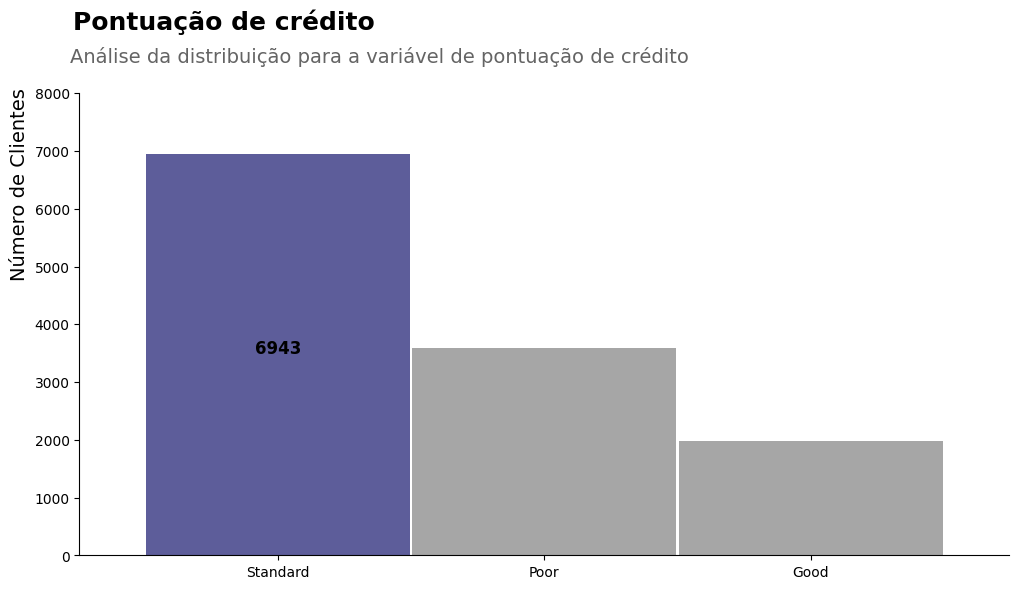

In [35]:
suptitle = 'Pontuação de crédito'
title = 'Análise da distribuição para a variável de pontuação de crédito'
colors=['#191970', '#808080', '#808080']

creditScore = df['Credit_Score'].value_counts()
creditScore.plot.bar(width=0.99, alpha=0.7, figsize=(12, 6), rot=False, color=colors).spines[['top', 'right']].set_visible(False)

plt.suptitle(suptitle, fontsize=18, y=1.02, horizontalalignment='left', x=0.12, color='black', weight='bold')
plt.title(title, fontsize=14, color='#646464', y=1.05, loc='left', x=-0.01)
plt.xlabel(None)
plt.ylabel('Número de Clientes', fontsize=14, horizontalalignment='left', y=0.595)
plt.text(0, 3500, '6943', fontsize=12, weight='bold', horizontalalignment='center')
plt.ylim(0, 8000)
plt.grid(False)
plt.show()

<p style='text-align: justify;'><font size=3.>Como já tinhamos visto, boa parte dos clientes do banco possui a pontuação de crédito classificada como Standard, com esse grupo ocupando 56% da base de clientes. É possível notar um desequilíbrio significativo entre esses grupos o que pode ser um desafio na hora de desenvolver modelos de aprendizagem de máquina, uma vez que modelos treinados em dados desequilibrados podem ser tendenciosos em direção à classe majoritária.</font></p>

### Análise renda mensal

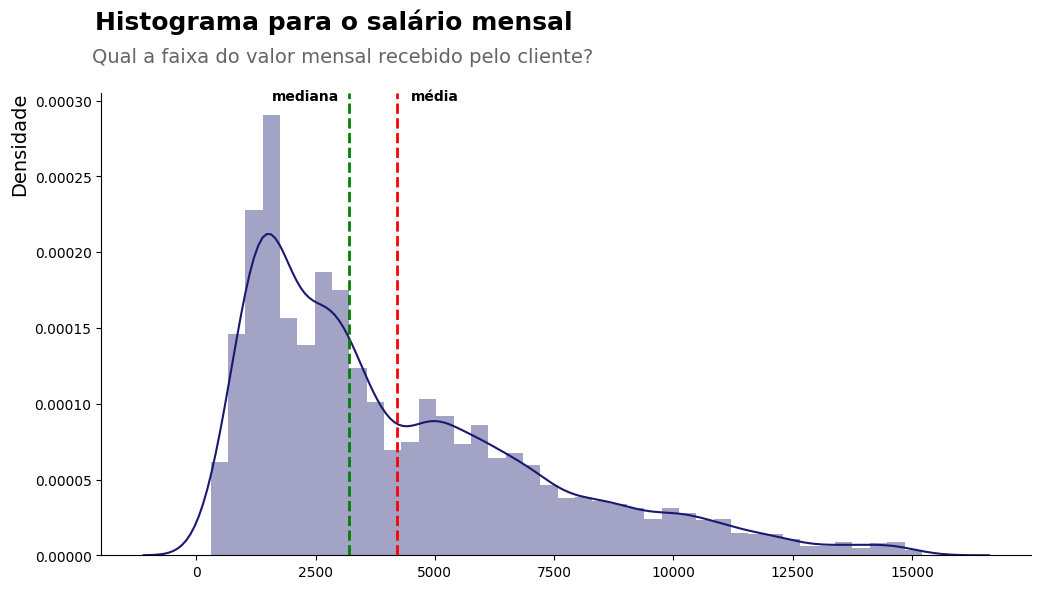

In [69]:
suptitle = 'Histograma para o salário mensal'
title = 'Qual a faixa do valor mensal recebido pelo cliente?'

ax = sns.distplot(df['Monthly_Inhand_Salary'], kde=True, color='#191970')
ax.figure.set_size_inches(12, 6)
ax.set_ylabel('Densidade', fontsize=14, horizontalalignment='left', y=0.779)
ax.set_xlabel(None)
ax.spines[['top', 'right']].set_visible(False)

plt.axvline(x=4210.79, color='r', linestyle='dashed', linewidth=2, label='Média')
plt.text(5000, 0.00030, 'média', fontsize=10, weight='bold', horizontalalignment='center')

plt.axvline(x=3196.99, color='g', linestyle='dashed', linewidth=2, label='Mediana')
plt.text(2300, 0.00030, 'mediana', fontsize=10, weight='bold', horizontalalignment='center')

plt.suptitle(suptitle, fontsize=18, y=1.02, horizontalalignment='left', x=0.12, color='black', weight='bold')
plt.title(title, fontsize=14, color='#646464', y=1.05, loc='left', x=-0.01)
plt.grid(False)
plt.show()

<p style='text-align: justify;'><font size=3.>O histograma é assimétrico e é possível perceber uma alta concentração na faixa de valores salariais mais baixos e também alguns valores muito mais altos. A média salarial é de, aproximadamente, R\$ 4210,79 com um desvio de R\$ 3093,55 o que indica uma dispersão substancial dos salários, sugerindo que temos alguns significativamente mais altos ou mais baixos do que a média. Além disso, a mediana de R\$ 3196,99 é menor o que também sugere que existem alguns valores mais altos no conjunto de dados que estão influenciando a média.</font></p>